# Recurrent Neural Nets - Fake News

The RNN (LSTM) architechture that we are using is shown below, a many to one RNN.

![RNNs](./images/manytoone.jpg)

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

We achieve 87% accuracy in a test set. However, the article in Second reference claims to have 93% accuracy. The main difference is that they seem to use a Bag of Words Model, which loses the order of words when sending into the ML algorithm. Also

## References:
1. Data: https://github.com/GeorgeMcIntire/fake_real_news_dataset
2. Classification using Scikit Learn: https://blog.kjamistan.com/comparing-scikit-learn-text-classifiers-on-a-fake-news-dataset/
3. Glove vectors: https://nlp.stanford.edu/projects/glove/



In [1]:
!pip install tqdm
# !conda install -y Pillow
!pip install Pillow

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split

import os
import urllib

from urllib.request import urlretrieve

from os import mkdir, makedirs, remove, listdir

from collections import Counter

# from utilties import *

    100% |████████████████████████████████| 5.9MB 221kB/s eta 0:00:01


Using TensorFlow backend.


In [2]:
# from utilties import *

from os.path import isfile, isdir, getsize
from tqdm import tqdm
import zipfile
from urllib.request import urlretrieve
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import numpy as np


class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


def downloadData(file, url):        
    if not isfile(file):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Fake News Dataset') as pbar:
            urlretrieve(url, file, pbar.hook)

    with zipfile.ZipFile(file) as f:
        f.extractall('./data/')
        

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [3]:
folder_path = 'data'

file = './data/fakenews.zip'
url = 'https://github.com/GeorgeMcIntire/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip'
downloadData(file, url)

#################################    
# Download GLOVE vector dataset
#################################
file = './data/glove.6B.zip'
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
downloadData(file, url)

with open('./data/glove.6B.50d.txt','rb') as f:
    lines = f.readlines()
    
glove_weights = np.zeros((len(lines), 50))
words = []
for i, line in enumerate(lines):
    word_weights = line.split()
    words.append(word_weights[0])
    weight = word_weights[1:]
    glove_weights[i] = np.array([float(w) for w in weight])
word_vocab = [w.decode("utf-8") for w in words]

word2glove = dict(zip(word_vocab, glove_weights))

Preprocessing steps: lower case, remove urls, some punctuations etc.

In [4]:
from keras.engine.topology import Layer
import keras.backend as K
from keras import initializers
import numpy as np

class Embedding2(Layer):

    def __init__(self, input_dim, output_dim, fixed_weights, embeddings_initializer='uniform', 
                 input_length=None, **kwargs):
        kwargs['dtype'] = 'int32'
        if 'input_shape' not in kwargs:
            if input_length:
                kwargs['input_shape'] = (input_length,)
            else:
                kwargs['input_shape'] = (None,)
        super(Embedding2, self).__init__(**kwargs)
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = embeddings_initializer
        self.fixed_weights = fixed_weights
        self.num_trainable = input_dim - len(fixed_weights)
        self.input_length = input_length
        
        w_mean = fixed_weights.mean(axis=0)
        w_std = fixed_weights.std(axis=0)
        self.variable_weights = w_mean + w_std*np.random.randn(self.num_trainable, output_dim)

    def build(self, input_shape, name='embeddings'):        
        fixed_weight = K.variable(self.fixed_weights, name=name+'_fixed')
        variable_weight = K.variable(self.variable_weights, name=name+'_var')
        
        self._trainable_weights.append(variable_weight)
        self._non_trainable_weights.append(fixed_weight)
        
        self.embeddings = K.concatenate([fixed_weight, variable_weight], axis=0)
        
        self.built = True

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        out = K.gather(self.embeddings, inputs)
        return out

    def compute_output_shape(self, input_shape):
        if not self.input_length:
            input_length = input_shape[1]
        else:
            input_length = self.input_length
        return (input_shape[0], input_length, self.output_dim)


In [5]:
df = pd.read_csv('data/fake_or_real_news.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.title = df.title.str.lower()
df.text = df.text.str.lower()

df.title = df.title.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.text = df.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.title = df.title.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.title = df.title.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.text = df.text.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.title = df.title.str.replace(r'\.',' . ') #replace periods with a single one
df.text = df.text.str.replace(r'\.',' . ') #replace multple periods with a single one
df.title = df.title.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.title = df.title.str.strip() 
df.text = df.text.str.strip() 
print(df.shape)
df.head()

(6335, 3)


,title,text,label
0,you can smell hillarys fear,daniel greenfield a shillman journalism fellow...,FAKE
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,kerry to go to paris in gesture of sympathy,u . s . secretary of state john f . kerry said...,REAL
3,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 the les...,FAKE
4,the battle of new york why this primary matters,its primary day in new york and frontrunners h...,REAL


Get all the unique words. We will only consider words that have been used more than 5 times. Finally from this we create a dictionary mapping words to integers.

Once this is done we will create a list of reviews where the words are converted to ints.

In [6]:
all_text = ' '.join(df.text.values)
words = all_text.split()
u_words = Counter(words).most_common()
u_words_counter = u_words
u_words_frequent = [word[0] for word in u_words if word[1]>5] # we will only consider words that have been used more than 5 times

u_words_total = [k for k,v in u_words_counter]
word_vocab = dict(zip(word_vocab, range(len(word_vocab))))
word_in_glove = np.array([w in word_vocab for w in u_words_total])

words_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if is_true]
words_not_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if not is_true]

print('Fraction of unique words in glove vectors: ', sum(word_in_glove)/len(word_in_glove))

# # create the dictionary
word2num = dict(zip(words_in_glove,range(len(words_in_glove))))
len_glove_words = len(word2num)
freq_words_not_glove = [w for w in words_not_in_glove if w in u_words_frequent]
b = dict(zip(freq_words_not_glove,range(len(word2num), len(word2num)+len(freq_words_not_glove))))
word2num = dict(**word2num, **b)
word2num['<Other>'] = len(word2num)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else word2num['<Other>'] 
             for word in content.split()] for content in df.text.values]

print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])
print('And once this is converted back to words, it looks like: ')
print(' '.join([num2word[i] for i in int_text[0][:20]]))

Fraction of unique words in glove vectors:  0.668536737092
The number of unique words are:  86806
The first review looks like this: 
[4447, 12884, 5, 59768, 2855, 1229, 24, 0, 573, 483, 8, 5, 56, 243, 2518, 2856, 10, 1455, 1642, 1]
And once this is converted back to words, it looks like: 
daniel greenfield a <Other> journalism fellow at the freedom center is a new york writer focusing on radical islam .


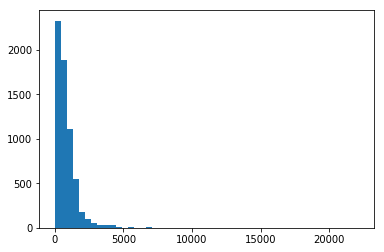

In [7]:
plt.hist([len(t) for t in int_text],50)
plt.show()

In [8]:
print('The number of articles greater than 500 in length is: ', np.sum(np.array([len(t)>500 for t in int_text])))
print('The number of articles less than 50 in length is: ', np.sum(np.array([len(t)<50 for t in int_text])))

The number of articles greater than 500 in length is:  3714
The number of articles less than 50 in length is:  440


You cannot pass differing lengths of sentences to the algorithm. Hence we shall prepad the sentence with `<PAD>`. Sequences less than 500 in length will be prepadded and sequences that are longer than 500 will be truncated. It is assumed that the sentiment of the review can be asserted from the first 500 words.

In [9]:
num2word[len(word2num)] = '<PAD>'
word2num['<PAD>'] = len(word2num)

for i, t in enumerate(int_text):
    if len(t)<500:
        int_text[i] = [word2num['<PAD>']]*(500-len(t)) + t
    elif len(t)>500:
        int_text[i] = t[:500]
    else:
        continue

x = np.array(int_text)
y = (df.label.values=='REAL').astype('int')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

A real news article:

In [10]:
df[df.label=='REAL'].text.values[0]

'u . s . secretary of state john f . kerry said monday that he will stop in paris later this week amid criticism that no top american officials attended sundays unity march against terrorism . kerry said he expects to arrive in paris thursday evening as he heads home after a week abroad . he said he will fly to france at the conclusion of a series of meetings scheduled for thursday in sofia bulgaria . he plans to meet the next day with foreign minister laurent fabius and president francois hollande then return to washington . the visit by kerry who has family and childhood ties to the country and speaks fluent french could address some of the criticism that the united states snubbed france in its darkest hour in many years . the french press on monday was filled with questions about why neither president obama nor kerry attended sundays march as about 40 leaders of other nations did . obama was said to have stayed away because his own security needs can be taxing on a country and kerry

A fake news article:

In [11]:
df[df.label=='FAKE'].text.values[0]

'daniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing on radical islam . in the final stretch of the election hillary rodham clinton has gone to war with the fbi . the word unprecedented has been thrown around so often this election that it ought to be retired . but its still unprecedented for the nominee of a major political party to go war with the fbi . but thats exactly what hillary and her people have done . coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillarys opponent in this election . the fbi is under attack by everyone from obama to cnn . hillarys people have circulated a letter attacking comey . there are currently more media hit pieces lambasting him than targeting trump . it wouldnt be too surprising if the clintons or their allies were to start running attack ads against the fbi . the fbis leadership is being warned that the entire leftwing 

## Many to One LSTM

### Basic Method:
This method is no different to the method utilised in the sentiment analysis lesson.

In [12]:
model = Sequential()
model.add(Embedding(len(word2num), 50)) # , batch_size=batch_size
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          2988500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,018,005
Trainable params: 3,018,005
Non-trainable params: 0
_________________________________________________________________


In [13]:
batch_size = 128
epochs = 5
model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test))

Train on 5701 samples, validate on 634 samples
Epoch 1/1
5701/5701 [==============================] - 41s 7ms/step - loss: 0.6293 - acc: 0.6648 - val_loss: 0.3867 - val_acc: 0.8549


### Method 2: Fixed Embeddings
This is where we use the `Embedding2` class to which we give a set of weights which remain the same through training. Note especially the number of trainable parameters in the summary.

In [14]:
model = Sequential()
model.add(Embedding2(len(word2num), 50,
                    fixed_weights=np.array([word2glove[w] for w in words_in_glove]))) # , batch_size=batch_size
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# rmsprop = keras.optimizers.RMSprop(lr=1e-4)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding2_1 (Embedding2)    (None, None, 50)          2988500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,018,005
Trainable params: 116,355
Non-trainable params: 2,901,650
_________________________________________________________________


I may heave cheated and run the following block 3 times. Good thing about Keras is that it remembers the last learning rate and goes from there.

In [15]:
batch_size = 128
model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_data=(X_test, y_test))

Train on 5701 samples, validate on 634 samples
Epoch 1/15
5701/5701 [==============================] - 38s 7ms/step - loss: 0.6409 - acc: 0.6369 - val_loss: 0.5756 - val_acc: 0.7066
Epoch 2/15
5701/5701 [==============================] - 36s 6ms/step - loss: 0.5710 - acc: 0.7044 - val_loss: 0.5717 - val_acc: 0.7224
Epoch 3/15
5701/5701 [==============================] - 35s 6ms/step - loss: 0.5660 - acc: 0.7088 - val_loss: 0.5524 - val_acc: 0.7287
Epoch 4/15
5701/5701 [==============================] - 37s 6ms/step - loss: 0.5456 - acc: 0.7232 - val_loss: 0.4942 - val_acc: 0.7603
Epoch 5/15
5701/5701 [==============================] - 36s 6ms/step - loss: 0.5289 - acc: 0.7606 - val_loss: 0.4950 - val_acc: 0.7666
Epoch 6/15
5701/5701 [==============================] - 35s 6ms/step - loss: 0.4831 - acc: 0.7783 - val_loss: 0.4679 - val_acc: 0.7997
Epoch 7/15
5701/5701 [==============================] - 38s 7ms/step - loss: 0.4731 - acc: 0.7783 - val_loss: 0.4165 - val_acc: 0.8281
Epoch 8/

In [16]:
batch_size = 128
model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_data=(X_test, y_test))

Train on 5701 samples, validate on 634 samples
Epoch 1/15
5701/5701 [==============================] - 35s 6ms/step - loss: 0.4452 - acc: 0.8078 - val_loss: 0.4205 - val_acc: 0.8249
Epoch 2/15
5701/5701 [==============================] - 35s 6ms/step - loss: 0.4023 - acc: 0.8325 - val_loss: 0.4309 - val_acc: 0.8155
Epoch 3/15
5701/5701 [==============================] - 36s 6ms/step - loss: 0.3959 - acc: 0.8209 - val_loss: 0.4972 - val_acc: 0.7634
Epoch 4/15
5701/5701 [==============================] - 36s 6ms/step - loss: 0.3869 - acc: 0.8309 - val_loss: 0.3719 - val_acc: 0.8596
Epoch 5/15
5701/5701 [==============================] - 35s 6ms/step - loss: 0.4195 - acc: 0.8114 - val_loss: 0.3889 - val_acc: 0.8486
Epoch 6/15
5701/5701 [==============================] - 35s 6ms/step - loss: 0.4538 - acc: 0.7857 - val_loss: 0.4385 - val_acc: 0.8139
Epoch 7/15
5701/5701 [==============================] - 36s 6ms/step - loss: 0.4061 - acc: 0.8149 - val_loss: 0.3738 - val_acc: 0.8565
Epoch 8/

In [17]:
batch_size = 128
model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_data=(X_test, y_test))

Train on 5701 samples, validate on 634 samples
Epoch 1/15
5701/5701 [==============================] - 37s 6ms/step - loss: 0.3340 - acc: 0.8591 - val_loss: 0.4075 - val_acc: 0.8170
Epoch 2/15
5701/5701 [==============================] - 37s 6ms/step - loss: 0.3414 - acc: 0.8581 - val_loss: 0.3367 - val_acc: 0.8486
Epoch 3/15
5701/5701 [==============================] - 36s 6ms/step - loss: 0.3175 - acc: 0.8665 - val_loss: 0.3124 - val_acc: 0.8675
Epoch 4/15
5701/5701 [==============================] - 36s 6ms/step - loss: 0.3227 - acc: 0.8577 - val_loss: 0.2967 - val_acc: 0.8896
Epoch 5/15
5701/5701 [==============================] - 37s 6ms/step - loss: 0.3087 - acc: 0.8739 - val_loss: 0.4130 - val_acc: 0.8170
Epoch 6/15
5701/5701 [==============================] - 37s 6ms/step - loss: 0.3211 - acc: 0.8614 - val_loss: 0.3526 - val_acc: 0.8281
Epoch 7/15
5701/5701 [==============================] - 37s 7ms/step - loss: 0.3136 - acc: 0.8705 - val_loss: 0.2904 - val_acc: 0.8864
Epoch 8/

In [89]:
sentence = "President Trump is the greatest president of all time period .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
sentence_prediction = model.predict(sentence_num[None,:])
if sentence_prediction < 0.5: 
    print('FAKE NEWS! %0.5f' % sentence_prediction) 
else:
    print('REAL NEWS! %0.5f' % sentence_prediction)

REAL NEWS! 0.94919


In [90]:
' '.join([num2word[w] for w in sentence_num])

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

In [91]:
sentence = "The chemicals in the water is turning the freaking frogs gay says cnn . ".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
sentence_prediction = model.predict(sentence_num[None,:])
if sentence_prediction < 0.5: 
    print('FAKE NEWS! %0.5f' % sentence_prediction) 
else:
    print('REAL NEWS! %0.5f' % sentence_prediction)

REAL NEWS! 0.86151


In [92]:
sentence = "North korea is testing out missiles on americans living overseas .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
sentence_prediction = model.predict(sentence_num[None,:])
if sentence_prediction < 0.5: 
    print('FAKE NEWS! %0.5f' % sentence_prediction) 
else:
    print('REAL NEWS! %0.5f' % sentence_prediction)

REAL NEWS! 0.57424


In [93]:
sentence = "ISS lecturer Sam GU Zhan earns the biggest salary among all says National University of Singapore .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
sentence_prediction = model.predict(sentence_num[None,:])
if sentence_prediction < 0.5: 
    print('FAKE NEWS! %0.5f' % sentence_prediction) 
else:
    print('REAL NEWS! %0.5f' % sentence_prediction)

FAKE NEWS! 0.16170


In [94]:
model.evaluate(X_test, y_test)

634/634 [==============================] - 2s 3ms/step


[0.26412493300738771, 0.90063091520255301]

---